<a href="https://colab.research.google.com/github/dhruvgrover1251/Brain_Tumor_Detection_Project/blob/master/Brain_tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Importing libraries<h1>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Input, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Flatten,Dense,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
from os import listdir
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os
from google.colab import drive
drive.mount("/content/gdrive")


%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h1>Data Preprocessing</h1>
 Cropping brain from image using contours

In [2]:
def crop_brain_contours( image ,plot=False):
  # load the image, convert it to grayscale, and blur it slightly
  image = cv2.imread(image)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  # find contours in thresholded image, then grab the largest
  # one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # determine the most extreme points along the contour
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.tick_params(axis="both",which="both",top=False,bottom=False,left=False,right=False,labeltop=False,labelbottom=False,labelleft=False,labelright=False)
    plt.title("Original_image")
    plt.show()
    plt.figure()
    plt.subplot(1,2,2)
    plt.imshow(new_image)
    plt.tick_params(axis="both",which="both",top=False,bottom=False,left=False,right=False,labeltop=False,labelbottom=False,labelleft=False,labelright=False)
    plt.title("Cropped_image")
    plt.show()

  return image


Example of a image that is cropped

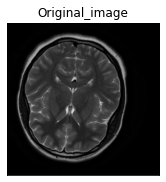

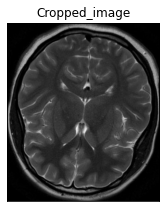

In [3]:
example_image="/content/gdrive/My Drive/augumented_data/no/aug_1 no._0_1061..jpg"
example_new_image=crop_brain_contours(example_image,True)

<h1>Loading Data</h1><br>
1.Reading and cropping.<br>
2.Resizing to give input to neural network.<br>
3.Applying normalization.<br>
3.Appending images to X and labels to Y.<br>
4.Shuffling X and Y.

In [4]:

def load_data(dir_list,image_size):
  X=[]
  Y=[]
  image_width,image_height=image_size
  
  for directory in listdir(dir_list):
    for filename in listdir(dir_list+"/"+directory):
      #image=cv2.imread(dir_list+"/"+directory+"/"+filename)
      image=crop_brain_contours(dir_list+"/"+directory+"/"+filename,False)
      image=cv2.resize(image,(image_width,image_height),interpolation=cv2.INTER_CUBIC)
      image=image/255
      X.append(image)
      if directory=="yes":
        Y.append([1])
      else:
        Y.append([0])
  X,Y=shuffle(X,Y)
  X=np.array(X)
  Y=np.array(Y)
  print(f"Number of examples : {len(X)}")
  print(f"X shape is : {X.shape}")
  print(f"Y shape is : {Y.shape}")

  return X,Y



Storing augumented data in new directory named augumented_data

In [5]:
image_width,image_height=(240,240)
augumented_data_path="/content/gdrive/My Drive/augumented_data"
X,Y=load_data(augumented_data_path,(image_width,image_height))

Number of examples : 2065
X shape is : (2065, 240, 240, 3)
Y shape is : (2065, 1)


In [6]:
def plot_images(X,Y,n=50):
  # n is number of examples to plot
  for labels in [0,1]:
    images = X[np.argwhere(Y == labels)]
    n_images = images[:n]
    columns_n=10
    rows_n=int(n/columns_n)
    plt.figure(figsize=(20,10))
    i=1 # current plot
    for image in n_images:
        plt.subplot(rows_n, columns_n, i)
        plt.imshow(image[0])
        # remove ticks
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        i += 1
    label_to_str = lambda label: "Yes" if label == 1 else "No"
    plt.suptitle(f"Brain Tumor: {label_to_str(labels)}")
    plt.show()
        

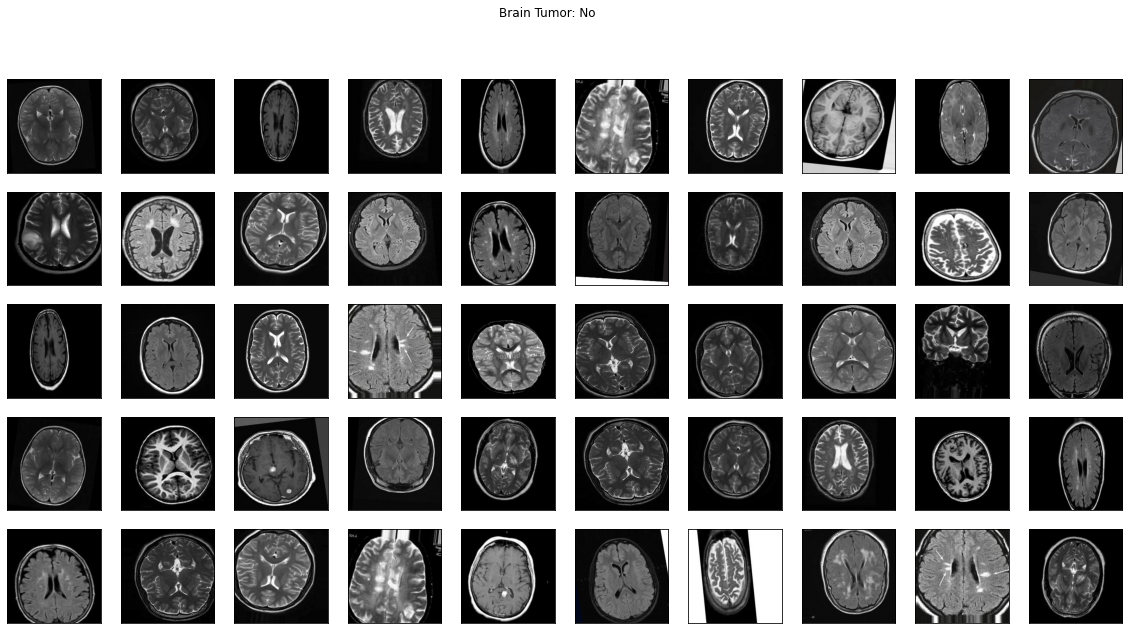

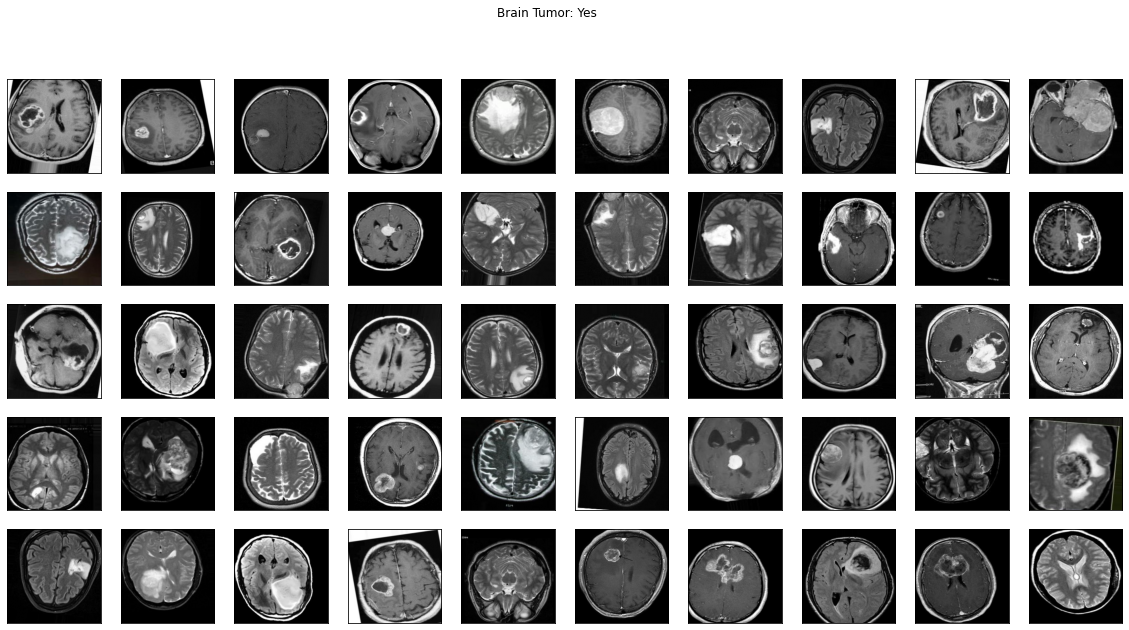

In [7]:
plot_images(X,Y)

<h1>Splitting data into training, cross-validation and test set

In [8]:
def split_data(X, Y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        Y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, test_size=test_size)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, test_size=0.5)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test


Let's use the following way to split:

1.70% of the data for training.<br>
2.15% of the data for validation.<br>
3.15% of the data for testing.

In [9]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
#nicely formatted time string
def  hms_string(sec_elapsed):
  h=int(sec_elapsed/(60*60))
  m=int((sec_elapsed%(60*60))/60)
  s=sec_elapsed%60
  return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [13]:


def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")



In [14]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

<h1>Transfer Learning<h1>

Using VGG16(without fully connected layers) with parameters already trainned on Imagenet.

In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(240,240,3),pooling=max)

Adding some trainnable layers to the VGG16 model

In [ ]:
VGG16=tf.keras.Sequential()
VGG16.add(vgg16)
VGG16.add(Dropout(0.3))
VGG16.add(Flatten())
VGG16.add(Dropout(0.5))
VGG16.add(Dense(1, activation='sigmoid'))
VGG16.layers[0].trainable = False
VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


Saving VGG models

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/VGGmodels/{epoch:03d}-{val_accuracy:.2f}"#"models/{epoch:03d}-{val_loss:.2f}.h5"#"training_1/cp.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")

In [ ]:
start_time = time.time()

VGG16.fit(x=X_train, y=Y_train, batch_size=32, epochs=125, validation_data=(X_val, Y_val),callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/125
46/46 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.7156
Epoch 00001: val_accuracy improved from -inf to 0.83871, saving model to /content/gdrive/My Drive/VGGmodels/001-0.84
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/VGGmodels/001-0.84/assets
46/46 [==============================] - 27s 586ms/step - loss: 0.5862 - accuracy: 0.7156 - val_loss: 0.3572 - val_accuracy: 0.8387
Epoch 2/125
46/46 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8298
Epoch 00002: val_accuracy improved from 0.83871 to 0.90323, saving model to /content/gdrive/My Drive/VGGmodels/002-0.90
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/VGGmodels/002-0.90/assets
46/46 [==============================] - 23s 496ms/step - loss: 0.3683 - accuracy: 0.8298 - val_loss: 0.2544 - val_accuracy: 0.9032
Epoch 3/125
46/46 [==============================] - ETA

maximum validation accuracy is at 75th epoch

In [ ]:
#rm -rf /content/gdrive/My Drive/VGGmodels

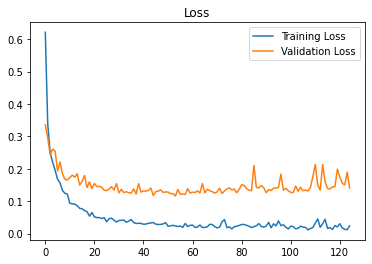

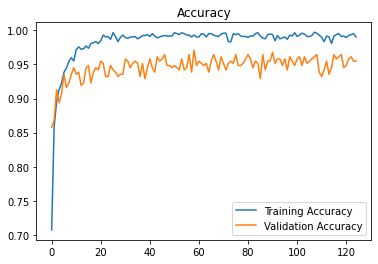

In [ ]:
history = VGG16.history.history
plot_metrics(history)

In [ ]:
bestVGG16_model = load_model(filepath='/content/gdrive/My Drive/VGGmodels/075-0.99')


Calculating accuracy of best VGG16 model on test set

In [ ]:
loss, acc = bestVGG16_model.evaluate(x=X_test, y=Y_test)

10/10 [==============================] - 6s 575ms/step - loss: 0.0319 - accuracy: 0.9935


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")


Test Loss = 0.03190571814775467
Test Accuracy = 0.9935483932495117


In [ ]:
y_test_prob_v = bestVGG16_model.predict(X_test)

Calculating F1 score on test data

In [ ]:
f1score_test_VGG = compute_f1_score(Y_test, y_test_prob_v)
print(f"F1 score: {f1score_test_VGG}")

F1 score: 0.9467084639498432


Result Time

In [ ]:
data_percentage(Y) # whole data percentages

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [ ]:
print("Training Data:")
data_percentage(Y_train)
print("Validation Data:")
data_percentage(Y_val)
print("Testing Data:")
data_percentage(Y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.24913494809689%, number of pos examples: 755
Percentage of negative examples: 47.75086505190311%, number of neg examples: 690
Validation Data:
Number of examples: 310
Percentage of positive examples: 49.354838709677416%, number of pos examples: 153
Percentage of negative examples: 50.645161290322584%, number of neg examples: 157
Testing Data:
Number of examples: 310
Percentage of positive examples: 57.096774193548384%, number of pos examples: 177
Percentage of negative examples: 42.903225806451616%, number of neg examples: 133


InceptionV3

In [ ]:
INCV3=tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',  input_shape=(240,240,3),pooling=max)


In [ ]:
incv3=tf.keras.Sequential()
incv3.add(INCV3)
incv3.add(Dropout(0.3))
incv3.add(Flatten())
incv3.add(Dropout(0.5))
incv3.add(Dense(1, activation='sigmoid'))
incv3.layers[0].trainable = False
incv3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
incv3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73729     
Total params: 21,876,513
Trainable params: 73,729
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
checkpoint_path2 = "/content/gdrive/My Drive/inceptionv3/{epoch:03d}-{val_accuracy:.2f}"#"models/{epoch:03d}-{val_loss:.2f}.h5"#"training_1/cp.ckpt"
checkpoint2 = ModelCheckpoint(filepath=checkpoint_path2,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")

In [ ]:
start_time = time.time()

incv3.fit(x=X_train, y=Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val),callbacks=[checkpoint2])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.8173
Epoch 00001: val_accuracy improved from -inf to 0.88387, saving model to /content/gdrive/My Drive/inceptionv3/001-0.88
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/inceptionv3/001-0.88/assets
46/46 [==============================] - 60s 1s/step - loss: 0.8041 - accuracy: 0.8173 - val_loss: 0.5481 - val_accuracy: 0.8839
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.9017
Epoch 00002: val_accuracy improved from 0.88387 to 0.93548, saving model to /content/gdrive/My Drive/inceptionv3/002-0.94
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/inceptionv3/002-0.94/assets
46/46 [==============================] - 58s 1s/step - loss: 0.4111 - accuracy: 0.9017 - val_loss: 0.1547 - val_accuracy: 0.9355
Epoch 3/100
46/46 [==============================] - E

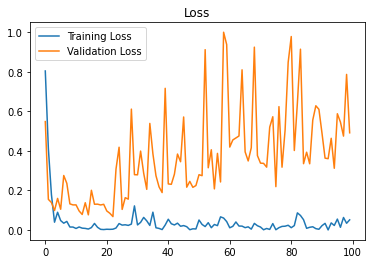

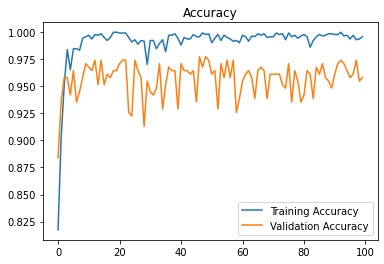

In [ ]:
history = incv3.history.history
plot_metrics(history)

Maximum validation accuracy at 47th epoch

In [15]:
bestincv3_model = load_model(filepath='/content/gdrive/My Drive/inceptionv3/047-0.98')

Calculating accuracy of best inception V3 model on test set



In [16]:
loss, acc = bestincv3_model.evaluate(x=X_test, y=Y_test)

10/10 [==============================] - 3s 290ms/step - loss: 0.0849 - accuracy: 0.9903


In [17]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.08490834385156631
Test Accuracy = 0.9903225898742676


In [18]:
Y_test_prob_i = bestincv3_model.predict(X_test)

Calculating F1 score on test data

In [19]:
f1score_val = compute_f1_score(Y_test, Y_test_prob_i)
print(f"F1 score: {f1score_val}")

F1 score: 0.9898989898989898


Result time

In [ ]:
print("Training Data:")
data_percentage(Y_train)
print("Validation Data:")
data_percentage(Y_val)
print("Testing Data:")
data_percentage(Y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.52595155709343%, number of pos examples: 759
Percentage of negative examples: 47.47404844290657%, number of neg examples: 686
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.54838709677419%, number of pos examples: 166
Percentage of negative examples: 46.45161290322581%, number of neg examples: 144
Testing Data:
Number of examples: 310
Percentage of positive examples: 51.61290322580645%, number of pos examples: 160
Percentage of negative examples: 48.38709677419355%, number of neg examples: 150


Resnet50

In [ ]:
resnet50=tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(240,240,3),pooling=max)


94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
RESNET50=tf.keras.Sequential()
RESNET50.add(resnet50)
RESNET50.add(Dropout(0.3))
RESNET50.add(Flatten())
RESNET50.add(Dropout(0.5))
RESNET50.add(Dense(1, activation='sigmoid'))
RESNET50.layers[0].trainable = False
RESNET50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
RESNET50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 131073    
Total params: 23,718,785
Trainable params: 131,073
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
checkpoint_path3 = "/content/gdrive/My Drive/RESNET50/{epoch:03d}-{val_accuracy:.2f}"#"models/{epoch:03d}-{val_loss:.2f}.h5"#"training_1/cp.ckpt"
checkpoint2 = ModelCheckpoint(filepath=checkpoint_path3,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")

In [ ]:
start_time = time.time()

RESNET50.fit(x=X_train, y=Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val),callbacks=[checkpoint2])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.5531 - accuracy: 0.6180
Epoch 00001: val_accuracy improved from -inf to 0.74839, saving model to /content/gdrive/My Drive/RESNET50/001-0.75
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RESNET50/001-0.75/assets
46/46 [==============================] - 44s 950ms/step - loss: 1.5531 - accuracy: 0.6180 - val_loss: 0.5843 - val_accuracy: 0.7484
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.6955
Epoch 00002: val_accuracy did not improve from 0.74839
46/46 [==============================] - 14s 306ms/step - loss: 0.8902 - accuracy: 0.6955 - val_loss: 1.2959 - val_accuracy: 0.6032
Epoch 3/100
46/46 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.7107
Epoch 00003: val_accuracy improved from 0.74839 to 0.77742, saving model to /content/gdrive/My Drive/RESNET50/003-

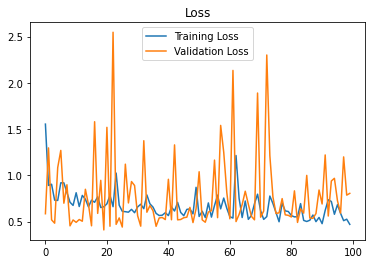

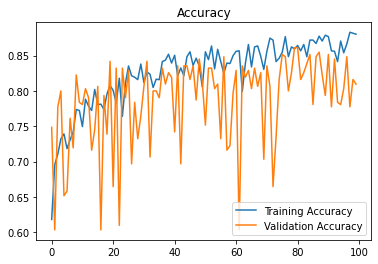

In [ ]:
history = RESNET50.history.history
plot_metrics(history)

Maximum validation accuracy at 80th epoch

In [ ]:
bestresnet50_model = load_model(filepath='/content/gdrive/My Drive/RESNET50/080-0.86')

In [ ]:
loss, acc = bestresnet50_model.evaluate(x=X_test, y=Y_test)

10/10 [==============================] - 2s 224ms/step - loss: 0.7349 - accuracy: 0.8258


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.7349048852920532
Test Accuracy = 0.8258064389228821


In [ ]:
Y_test_prob_r = bestresnet50_model.predict(X_test)

Calculating F1 score

In [ ]:
f1score_val = compute_f1_score(Y_test, Y_test_prob_r)
print(f"F1 score: {f1score_val}")

F1 score: 0.8402366863905325


In [ ]:
print("Training Data:")
data_percentage(Y_train)
print("Validation Data:")
data_percentage(Y_val)
print("Testing Data:")
data_percentage(Y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.24913494809689%, number of pos examples: 755
Percentage of negative examples: 47.75086505190311%, number of neg examples: 690
Validation Data:
Number of examples: 310
Percentage of positive examples: 51.935483870967744%, number of pos examples: 161
Percentage of negative examples: 48.064516129032256%, number of neg examples: 149
Testing Data:
Number of examples: 310
Percentage of positive examples: 54.516129032258064%, number of pos examples: 169
Percentage of negative examples: 45.483870967741936%, number of neg examples: 141


<h1>Trying with our own model with less number of total parameters.</h1>

In [ ]:
def model_built(input_shape):
  X_input = Input(input_shape) 
  X = ZeroPadding2D((2, 2))(X_input)
  Conv2D(32,(7,7),strides=(1,1),name="conv0")(X)
  X=BatchNormalization(axis=3,name="bn0")(X)
  X=Activation("relu")(X)
  X=MaxPool2D((4,4),name="max_pool_0")(X)
  X=MaxPool2D((4,4),name="max_pool_1")(X)
  X=Flatten()(X)
  X=Dense(1,activation="sigmoid")(X)
  model=Model(inputs=X_input,outputs=X,name="tumor_detection_model")

  return model


In [ ]:
IMG_shape=(image_width ,image_height ,3)

In [ ]:
own_model=model_built(IMG_shape)

In [ ]:
own_model.summary()


Model: "tumor_detection_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 244, 244, 3)       12        
_________________________________________________________________
activation (Activation)      (None, 244, 244, 3)       0         
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 61, 61, 3)         0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 15, 15, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 675)     

In [ ]:
own_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path4 = "/content/gdrive/My Drive/try_with_own_model/{epoch:03d}-{val_accuracy:.2f}"
checkpoint4 = ModelCheckpoint(filepath=checkpoint_path4,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")

In [ ]:
start_time = time.time()

own_model.fit(x=X_train, y=Y_train, batch_size=32, epochs=125, validation_data=(X_val, Y_val),callbacks=[checkpoint4])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/125
45/46 [============================>.] - ETA: 0s - loss: 0.7835 - accuracy: 0.6062
Epoch 00001: val_accuracy improved from -inf to 0.61935, saving model to /content/gdrive/My Drive/try_with_own_model/001-0.62
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/try_with_own_model/001-0.62/assets
46/46 [==============================] - 2s 47ms/step - loss: 0.7824 - accuracy: 0.6062 - val_loss: 0.6574 - val_accuracy: 0.6194
Epoch 2/125
45/46 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.6722
Epoch 00002: val_accuracy improved from 0.61935 to 0.64839, saving model to /content/gdrive/My Drive/try_with_own_model/002-0.65
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/try_with_own_model/002-0.65/assets
46/46 [==============================] - 2s 41ms/step - loss: 0.6592 - accuracy: 0.6727 - val_loss: 0.6303 - val_accuracy: 0.6484
Epoch 3/125
45/46 [=====

In [ ]:
history = own_model.history.history

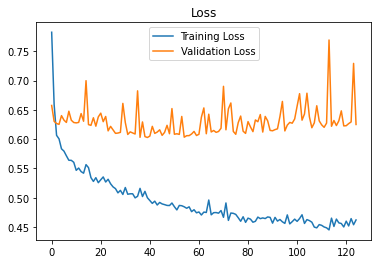

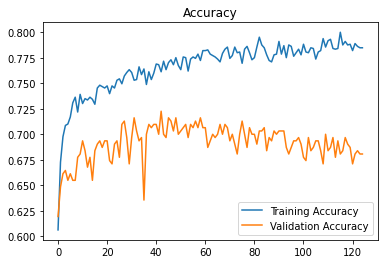

In [ ]:
plot_metrics(history)

model gives best validation accuracy on 43rd epoch

In [ ]:
besttry_with_own_model_model = load_model(filepath='/content/gdrive/My Drive/try_with_own_model/043-0.72')

In [ ]:
loss, acc = besttry_with_own_model_model.evaluate(x=X_test, y=Y_test)

10/10 [==============================] - 0s 10ms/step - loss: 0.5614 - accuracy: 0.7355


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.5613788366317749
Test Accuracy = 0.7354838848114014


In [ ]:
Y_test_prob_o = besttry_with_own_model_model.predict(X_test)


calculating F1 score

In [ ]:
f1score_val = compute_f1_score(Y_test, Y_test_prob_o)
print(f"F1 score: {f1score_val}")

F1 score: 0.757396449704142


Result time:

In [ ]:
print("Training Data:")
data_percentage(Y_train)
print("Validation Data:")
data_percentage(Y_val)
print("Testing Data:")
data_percentage(Y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.0795847750865%, number of pos examples: 767
Percentage of negative examples: 46.9204152249135%, number of neg examples: 678
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.225806451612904%, number of pos examples: 165
Percentage of negative examples: 46.774193548387096%, number of neg examples: 145
Testing Data:
Number of examples: 310
Percentage of positive examples: 49.354838709677416%, number of pos examples: 153
Percentage of negative examples: 50.645161290322584%, number of neg examples: 157
